# 偏微分方程和有限差分

- 通过费曼卡兹引理可将SDE直接转化成PDE

In [1]:
import numpy as np 
import pandas as pd
from scipy.stats import norm 
import scipy.interpolate as spi 
import scipy.sparse as sp
import scipy.linalg as sla
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.interpolate import splev, splrep
%matplotlib inline 
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False

np.random.seed(1031)

In [2]:
def Blackscholes( S0 = 100, K=100,r=.01,q=.01,T=1,sigma=.2,omega=1):
    discount = np.exp(-r*T)
    forward = S0*np.exp((r-q)*T)
    moneyness = np.log(forward/K)
    vol_sqrt_T = sigma * np.sqrt(T)

    d1 = moneyness/vol_sqrt_T + .5 * vol_sqrt_T
    d2 = d1 - vol_sqrt_T

    V = omega * discount * (forward*norm.cdf(omega*d1) - K*norm.cdf(omega*d2))
    return V

In [3]:
# 假设一个看跌期权，股价50，行权价60，利率3%，红利率1%，期限1年，波动率40%
(S0,K,r,q,T,sigma,omega) = (50,60,.03,.01,1,.4,-1)
Blackscholes(S0,K,r,q,T,sigma,omega)

13.583200733417277

## 有限差分

In [4]:
# 确定方程解域
(S,K,r,q,T,sigma,option_type) = (50,60,.03,.01,1,.4,'put')
(Smin,Smax,Ns,Nt) = (0,4*np.maximum(S,K),4,4)

In [5]:
def plot_solution_domain():
    fig = plt.figure(figsize=(4,4),dpi=100)
    ax = fig.add_subplot(1,1,1)

    points = np.array([0,1])
    xs,ys = np.meshgrid(points,points)

    ax.scatter(xs,ys,color='k')
    ax.plot(np.array([0,0]),np.array([0,1]),color = 'k',alpha=.2)
    ax.plot(np.array([1,1]),np.array([0,1]),color = 'k',alpha=.2)
    ax.plot(np.array([0,1]),np.array([0,0]),color = 'k',alpha=.2)
    ax.plot(np.array([0,1]),np.array([1,1]),color = 'k',alpha=.2)

    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())

    for spine in ax.spines.values():
        spine.set_visible(False)

    # 设定标题和纵轴标注
    ax.text(-0.1,0,'$0$',ha='center')
    ax.text(-0.1,1,'$240$',ha='center')
    ax.text(0,1.05,'$0$',ha='center')
    ax.text(1,1.05,'$1$',ha='center')

    ax.set_title('t',size=15,alpha = 0.5)
    ax.set_ylabel('S',size=15,alpha=0.5)

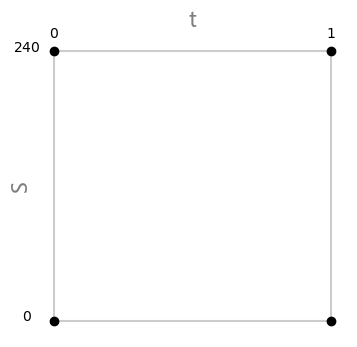

In [6]:
plot_solution_domain()

In [7]:
np.array([0,1])

array([0, 1])

## 建立网络
- {[S0,S1,S2,S3,S4] = [0,60,120,180,240]}
- {[t0,t1,t2,t3,t4] = [0,0.25,0.5,0.75,1]}

In [8]:
def plot_grid(S_arr,t_arr):
    fig = plt.figure(figsize=(6,6),dpi=200)
    ax = fig.add_subplot(1,1,1)

    t_mat,S_mat = np.meshgrid(t_arr,S_arr)
    ax.scatter(t_mat,S_mat,facecolor = 'black',s= 60,edgecolors=None)

    # 设定标题和纵轴标注
    ax.set_title('$0$--------------------$t$------------------------>$T$',size = 15,alpha=.5)
    ax.set_ylabel('$S_{\min}$-------------------$S$-------------------->$S_{\max}$',size = 15,alpha=.5)

    #去除横轴和纵轴的刻度，去掉边框
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())

    #设置方框隐形
    for spine in ax.spines.values():
        spine.set_visible(False)

    ds = S_arr[1] - S_arr[0]
    for t,S in zip(t_mat.flatten(),S_mat.flatten()):
        ax.text(t,S-ds/3,f'({t},{S})',ha = 'center',size=8)

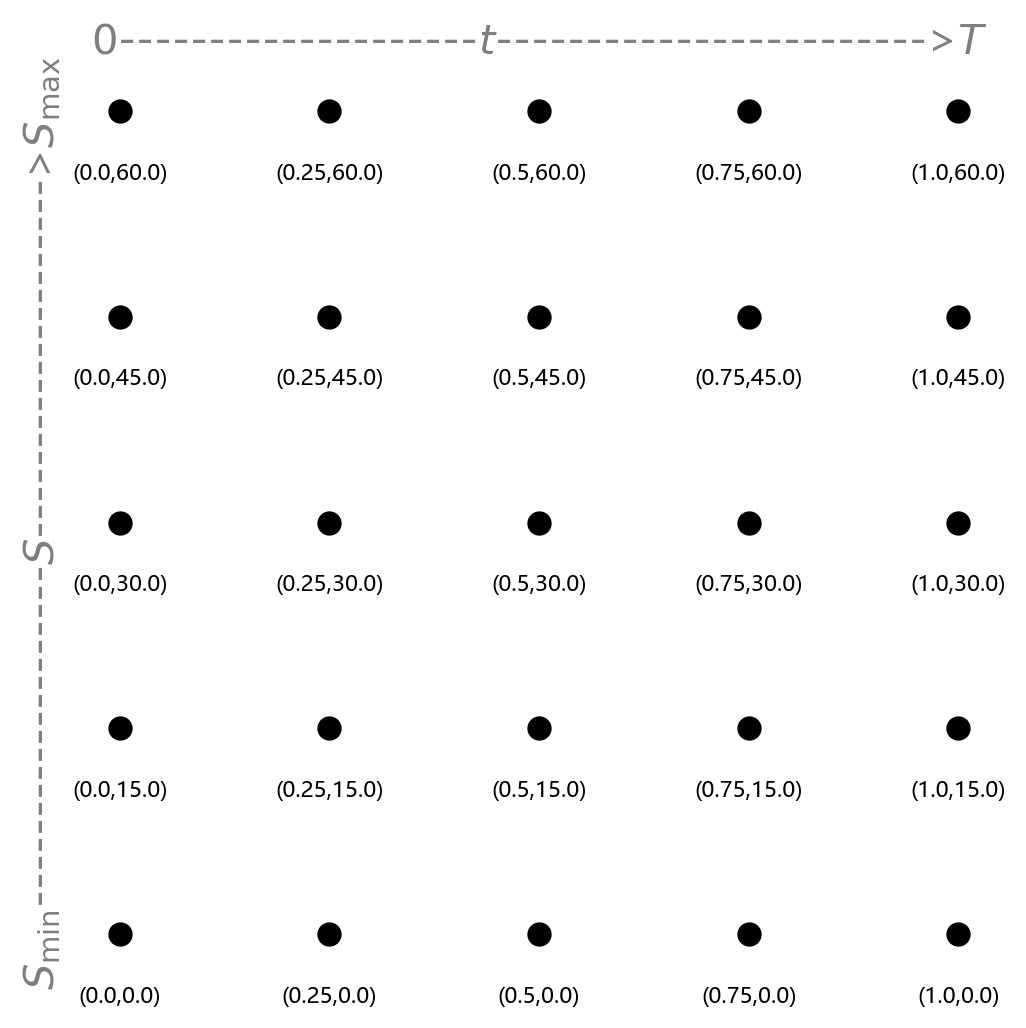

In [9]:
(Smin,Smax,Tmin,Tmax,Ns,Nt) = (0,np.maximum(S,K),0,T,4,4)
S_arr,t_arr = np.linspace(Smin,Smax,Ns+1),np.linspace(Tmin,Tmax,Nt+1)
plot_grid(S_arr,t_arr)

In [10]:
def plot_grid_withTBC(S_arr,t_arr):
    fig = plt.figure(figsize=(6,6),dpi=200)
    ax = fig.add_subplot(1,1,1)

    t_mat,S_mat = np.meshgrid(t_arr,S_arr)
    ax.scatter(t_mat,S_mat,facecolor = 'black',s= 60,edgecolors=None)

    # 设定标题和纵轴标注
    ax.set_title('$0$--------------------$t$------------------------>$T$',size = 15,alpha=.5)
    ax.set_ylabel('$S_{\min}$------------------$S$--------------------->$S_{\max}$',size = 15,alpha=.5)

    #去除横轴和纵轴的刻度，去掉边框
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())

    #设置方框隐形
    for spine in ax.spines.values():
        spine.set_visible(False)

    #给边界条件和终止条件加上颜色并标注
    ax.scatter(t_mat[[0,1]],S_mat[[0,-1]],facecolor = 'darkblue', s=60,edgecolors = None)
    ax.scatter(t_mat[:,-1],S_mat[:,-1],facecolor = 'red', s=60,edgecolors = None)
    
    dt = t_arr[1] - t_arr[0]
    ds = S_arr[1] - S_arr[0]
    ax.text(t_arr.mean(),S_arr.min()-S/10,'边界条件',ha = 'center',color='darkblue')
    ax.text(t_arr.mean(),S_arr.max()+S/20,'边界条件',ha = 'center',color='darkblue')
    ax.text(t_arr.max()+dt/5,S_arr.mean(),'终值条件',rotation = 'vertical',color='red' )

    return ax

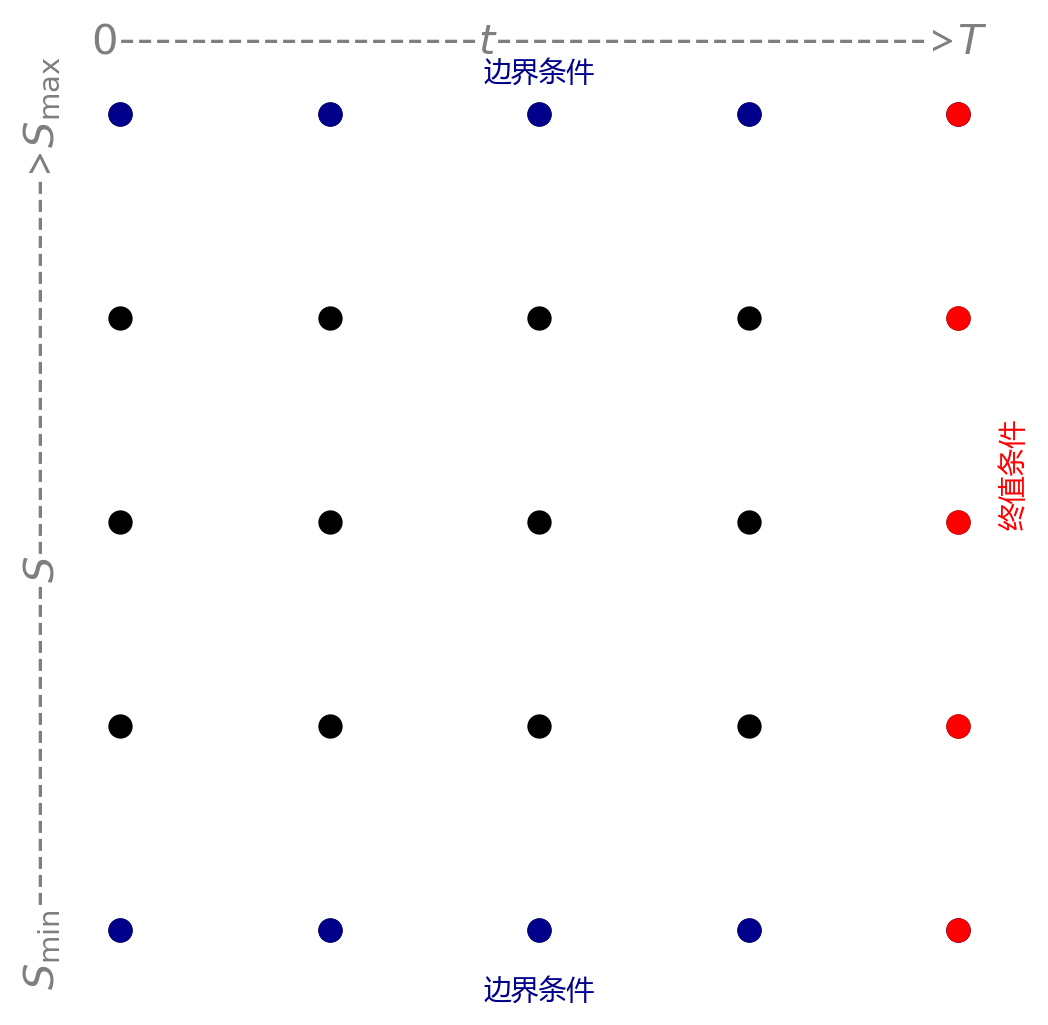

In [11]:
plot_grid_withTBC(S_arr,t_arr)

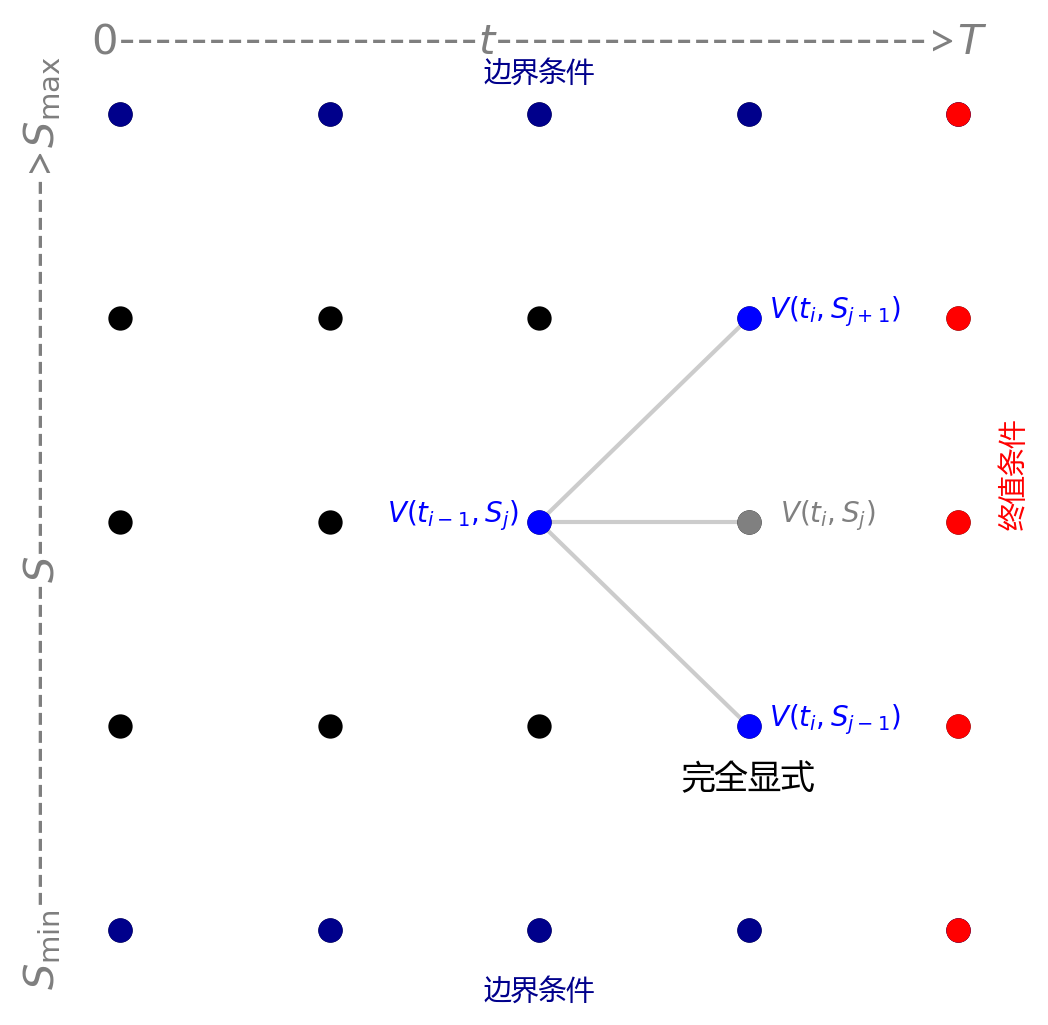

In [12]:
ax = plot_grid_withTBC(S_arr,t_arr)

size = 10
dt = t_arr[1] - t_arr[0]
ds = S_arr[1] - S_arr[0]

(i,j) = (2,2)
(ti,Sj) = (t_arr[i],S_arr[j])
ax.plot([ti,ti+dt],[Sj,Sj-ds],color='k',alpha=.2,zorder=0)
ax.plot([ti,ti+dt],[Sj,Sj],color='k',alpha=.2,zorder=0)
ax.plot([ti,ti+dt],[Sj,Sj+ds],color='k',alpha=.2,zorder=0)

ax.scatter(ti+dt,Sj,facecolor='grey',s=60,edgecolors=None,zorder=1)
ax.scatter(ti+dt,Sj-ds,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti+dt,Sj+ds,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti,Sj,facecolor='b',s=60,edgecolors=None,zorder=1)

ax.text(ti+dt,Sj-1.3*ds,'完全显式',ha='center',size=12)
ax.text(ti-0.1*dt,Sj,'$V(t_{i-1},S_j)$',ha='right',color = 'b',size=size)
ax.text(ti+1.1*dt,Sj-ds,'$V(t_{i},S_{j-1})$',ha='left',color = 'b',size=size)
ax.text(ti+1.15*dt,Sj,'$V(t_{i},S_{j})$',ha='left',color = 'grey',size=size)
ax.text(ti+1.1*dt,Sj+ds,'$V(t_{i},S_{j+1})$',ha='left',color = 'b',size=size)

plt.show()

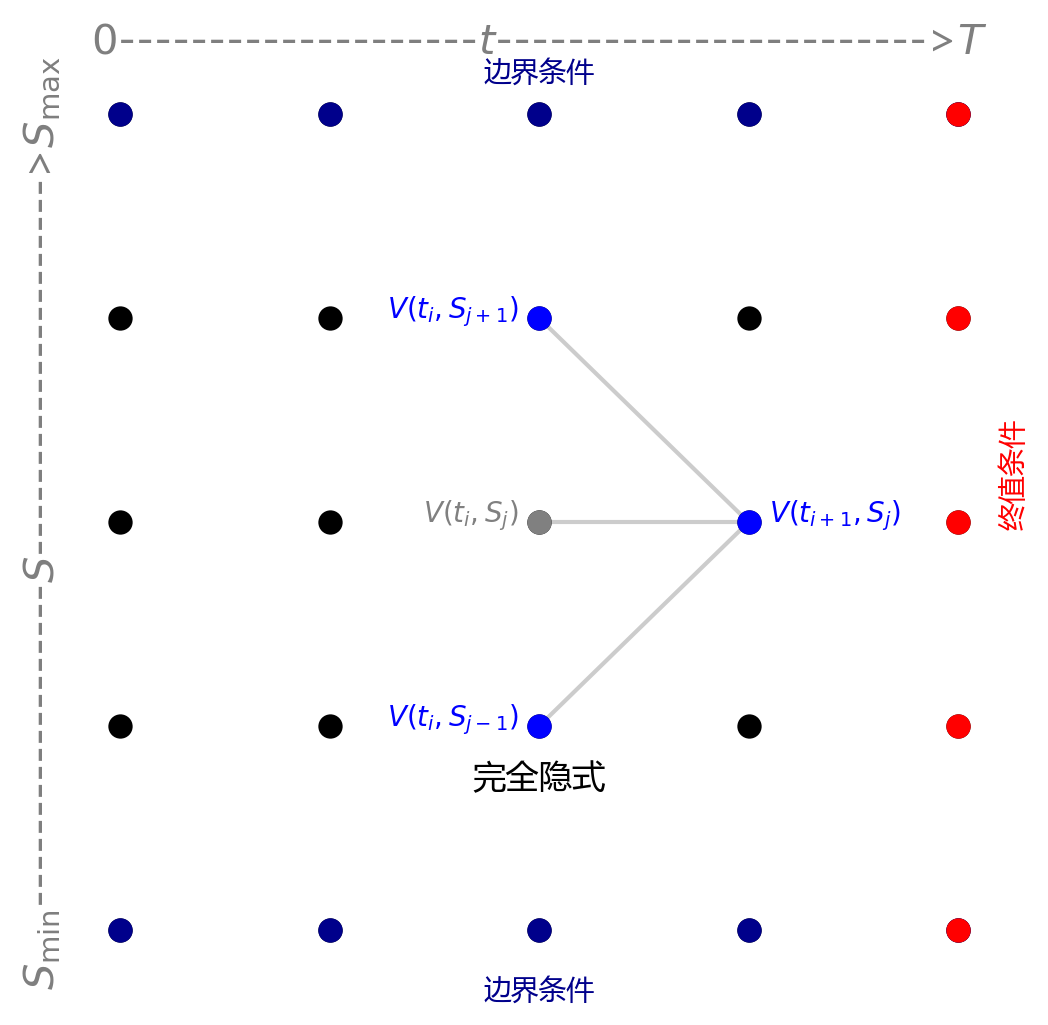

In [13]:
ax = plot_grid_withTBC(S_arr,t_arr)

size = 10
dt = t_arr[1] - t_arr[0]
ds = S_arr[1] - S_arr[0]

(i,j) = (2,2)
(ti,Sj) = (t_arr[i],S_arr[j])
ax.plot([ti,ti+dt],[Sj-ds,Sj],color='k',alpha=.2,zorder=0)
ax.plot([ti,ti+dt],[Sj,Sj],color='k',alpha=.2,zorder=0)
ax.plot([ti,ti+dt],[Sj+ds,Sj],color='k',alpha=.2,zorder=0)

ax.scatter(ti,Sj,facecolor='grey',s=60,edgecolors=None,zorder=1)
ax.scatter(ti,Sj-ds,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti,Sj+ds,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti+dt,Sj,facecolor='b',s=60,edgecolors=None,zorder=1)

ax.text(ti,Sj-1.3*ds,'完全隐式',ha='center',size=12)
ax.text(ti-0.1*dt,Sj-ds,'$V(t_{i},S_{j-1})$',ha='right',color = 'b',size=size)
ax.text(ti-.1*dt,Sj,'$V(t_{i},S_{j})$',ha='right',color = 'grey',size=size)
ax.text(ti-.1*dt,Sj+ds,'$V(t_{i},S_{j+1})$',ha='right',color = 'b',size=size)
ax.text(ti+1.1*dt,Sj,'$V(t_{i+1},S_{j})$',ha='left',color = 'b',size=size)

plt.show()

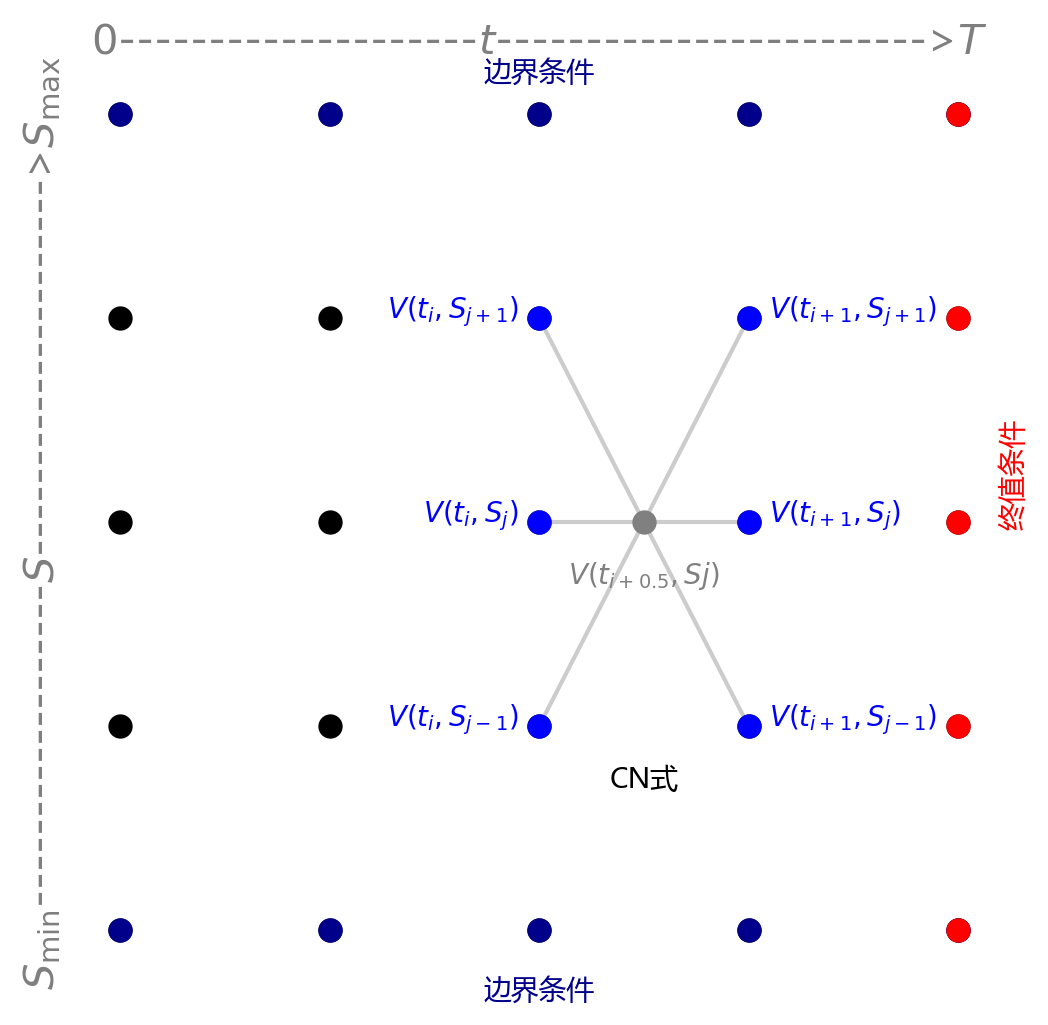

In [14]:
ax = plot_grid_withTBC(S_arr,t_arr)

size = 10
dt = t_arr[1] - t_arr[0]
ds = S_arr[1] - S_arr[0]

(i,j) = (2,2)
(ti,Sj) = (t_arr[i],S_arr[j])
ax.plot([ti,ti+dt],[Sj-ds,Sj+ds],color='k',alpha=.2,zorder=0)
ax.plot([ti,ti+dt],[Sj,Sj],color='k',alpha=.2,zorder=0)
ax.plot([ti,ti+dt],[Sj+ds,Sj-ds],color='k',alpha=.2,zorder=0)

ax.scatter(ti+0.5*dt,Sj,facecolor='grey',s = 60,edgecolors=None,zorder=1)

ax.scatter(ti,Sj,facecolor='grey',s=60,edgecolors=None,zorder=1)
ax.scatter(ti,Sj-ds,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti,Sj+ds,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti+dt,Sj,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti+dt,Sj-ds,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti+dt,Sj+ds,facecolor='b',s=60,edgecolors=None,zorder=1)
ax.scatter(ti,Sj,facecolor='b',s=60,edgecolors=None,zorder=1)

ax.text(ti+0.5*dt,Sj-1.3*ds,'CN式',ha='center',size=10)

ax.text(ti+0.5*dt,Sj-.3*ds,'$V(t_{i+0.5},S{j})$',ha='center',color = 'grey',size=10,zorder=1)
ax.text(ti-0.1*dt,Sj-ds,'$V(t_{i},S_{j-1})$',ha='right',color = 'b',size=size)
ax.text(ti-.1*dt,Sj+ds,'$V(t_{i},S_{j+1})$',ha='right',color = 'b',size=size)
ax.text(ti+1.1*dt,Sj,'$V(t_{i+1},S_{j})$',ha='left',color = 'b',size=size)
ax.text(ti-0.1*dt,Sj,'$V(t_{i},S_j)$',ha='right',color = 'b',size=size)
ax.text(ti+1.1*dt,Sj-ds,'$V(t_{i+1},S_{j-1})$',ha='left',color = 'b',size=size)
ax.text(ti+1.1*dt,Sj+ds,'$V(t_{i+1},S_{j+1})$',ha='left',color = 'b',size=size)

plt.show()

In [15]:
class OptionPricingMethod():

    def __init__(self,S,K,r,q,T,sigma,option_type):
        self.S=S
        self.K = K
        self.r = r
        self.q = q
        self.T = T
        self.sigma = sigma
        self.option_type = option_type
        self.is_call = (option_type[0].lower() == 'c')
        self.omega = 1 if self.is_call else -1

In [16]:
(S,K,r,q,T,sigma,option_type) = (50,60,0.03,0.01,1,0.4,'put')
opt = OptionPricingMethod(S,K,r,q,T,sigma,option_type)
opt.T

1

In [17]:
class FiniteDifference(OptionPricingMethod):

    def __init__(self,S,K,r,q,T,sigma,option_type,Smin,Smax,Ns,Nt):
        super().__init__(S,K,r,q,T,sigma,option_type)
        self.Smin = Smin
        self.Smax = Smax
        self.Ns = int(Ns)
        self.Nt = int(Nt)
        self.ds = (Smax-Smin)/Ns
        self.dt = T/Nt*1.0
        self.Svec = np.linspace(Smin,Smax,self.Ns+1)
        self.Tvec = np.linspace(0,T,self.Nt+1)
        self.grid = np.zeros(shape=(self.Ns+1,self.Nt+1))

    def _set_terminal_condition_(self):
        self.grid[:,-1] = np.maximum(self.omega*(self.Svec - self.K),0)

    def _set_boundary_condition(self):
        tau = self.Tvec[-1] - self.Tvec
        DFq = np.exp(-q*tau)
        DFr = np.exp(-r*tau)

        self.grid[0,:] = np.maximum(self.omega*(self.Svec[0]*DFq - self.K*DFr),0) #更新所有网格点的payoff
        self.grid[-1,:] = np.maximum(self.omega*(self.Svec[-1]*DFq - self.K*DFr),0)

    def _set_coefficient_(self):
        drift = (self.r-self.q)*self.Svec[1:-1]/self.ds
        diffusion_square = (self.sigma*self.Svec[1:-1]/self.ds)**2
        self.l = 0.5*(diffusion_square-drift)
        self.c = -diffusion_square-self.r
        self.u = 0.5*(diffusion_square+drift)

    def _solve_ (self):
        pass
    def _interpolate_(self):
        tck = spi.splrep(self.Svec,self.grid[:,0],k=3)
        return spi.splev(self.S,tck)

    def price(self):
        self._set_terminal_condition_()
        self._set_boundary_condition()
        self._set_coefficient_()
        self._set_matrix_()
        self._solve_()
        return self._interpolate_()


In [18]:
class FullyExplicitEu(FiniteDifference):

    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:],self.c,self.u[:-1]],[-1,0,1],format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M = self.I + self.dt*self.A

    def _solve_(self):
        for j in reversed(np.arange(self.Nt)):
            U = self.M.dot(self.grid[1:-1,j+1])
            U[0] += self.l[0]*self.dt*self.grid[0,j+1]
            U[-1] += self.u[-1]*self.dt*self.grid[-1,j+1]
            self.grid[1:-1,j] = U

In [19]:
(S,K,r,q,T,sigma,option_type) = (50,60,.03,.01,1,.4,'put')
(Smin,Smax,Ns,Nt) = (0,4*np.maximum(S,K),100,100)
option = FullyExplicitEu(S,K,r,q,T,sigma,option_type,Smin,Smax,Ns,Nt)
print(option.price())

-2.328090216118296e+54


In [20]:
class FullyImplicitEu(FiniteDifference):

    def _set_matrix_ (self):
        self.A = sp.diags([self.l[1:],self.c,self.u[:-1]],[-1,0,1],format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M = self.I - self.dt*self.A

    def _solve_(self):
        _, M_lower,M_upper = sla.lu(self.M.toarray())

        for j in reversed(np.arange(self.Nt)):
            U = self.grid[1:-1,j+1].copy()
            U[0] += self.l[0] * self.dt * self.grid[0,j]
            U[-1] += self.u[-1] * self.dt * self.grid[-1,j]
            Ux = sla.solve_triangular( M_lower,U,lower=True)
            self.grid[1:-1,j] = sla.solve_triangular(M_upper,Ux,lower=False)


In [21]:
option2 = FullyImplicitEu(S,K,r,q,T,sigma,option_type,Smin,Smax,Ns,Nt)
print(option2.price())

13.56466955284233


In [22]:
option2 = FullyImplicitEu(S,K,r,q,T,sigma,option_type,Smin,Smax,100,100)
print(option2.price())

13.56466955284233


In [23]:
Blackscholes(S,K,r,q,T,sigma,omega)

13.583200733417277